# Regression Using KNN

## Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
cars_df = pd.read_csv( "final_cars_maruti.csv" )

In [3]:
cars_df.sample(5)

,Location,Fuel_Type,Transmission,Owner_Type,Seats,Price,Age,Model,Mileage,Power,KM_Driven
604,Ahmedabad,Petrol,Manual,First,5,3.91,8,swift,18.60,85.8,48
692,Mumbai,Petrol,Manual,First,5,6.55,5,ciaz,20.73,91.1,30
598,Pune,Petrol,Manual,First,5,2.30,10,wagon,18.90,67.1,91
188,Kolkata,Diesel,Manual,First,5,3.89,6,swift,26.59,74.0,57
318,Kolkata,Petrol,Manual,First,5,4.25,6,swift,19.10,85.8,48


In [4]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Location      1010 non-null   object 
 1   Fuel_Type     1010 non-null   object 
 2   Transmission  1010 non-null   object 
 3   Owner_Type    1010 non-null   object 
 4   Seats         1010 non-null   int64  
 5   Price         1010 non-null   float64
 6   Age           1010 non-null   int64  
 7   Model         1010 non-null   object 
 8   Mileage       1010 non-null   float64
 9   Power         1010 non-null   float64
 10  KM_Driven     1010 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 86.9+ KB


## What is a Neighbour?

Let's say we only know two attributes of cars.

- Age
- KM_Driven

In [5]:
cars_subset_df = cars_df[['Age', 
                          'KM_Driven', 
                          'Price']].sample(10, random_state = 70)

In [6]:
cars_subset_df.reset_index(inplace=True, 
                           drop=True) 
cars_subset_df

,Age,KM_Driven,Price
0,5,74,4.15
1,8,52,2.90
2,5,59,8.50
3,2,17,7.97
4,5,27,4.45
5,4,12,6.75
6,4,30,6.25
7,10,130,3.65
8,6,54,4.50
9,4,4,3.00


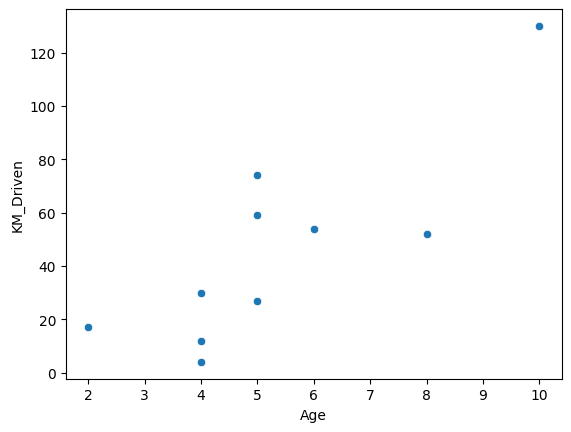

In [7]:
sn.scatterplot(cars_subset_df,
               x = 'Age',
               y = 'KM_Driven');

- **Cars with very similar attributes i.e. similar age and kilometer drivern are called neighbors.**
- Similar cars will have shorter distance i.e. they will be nearer to each other on the euclidean space of age and kilometer driven compared to dissimilar cars.
- The distane between the car **x** and car **y** is given by:

$ dist_{xy}  = \sqrt {\left( age_{x}-age_{y}\right)^2 + \left( km_{x}-km_{y}\right)^2 } $

https://en.wikipedia.org/wiki/Euclidean_distance

### What is the distance between two cars

Let's find which cars from this sample set are nearer to a car with 4 years old and has been driven around 30 kilometers. 

In [8]:
def cardist(age_x, km_x, age_y, km_y):
    return  np.round(np.sqrt((age_x - age_y)**2 
                           + (km_x - km_y)**2), 2)

In [9]:
cardist(10, 50, #car 1
        4, 30)  #car 2

20.88

In [10]:
cars_subset_df['dist'] = (cars_subset_df
                          .apply(lambda rec:                                               
                                 cardist(rec['Age'], rec['KM_Driven'],                                                       
                                         4, 30), 
                                 axis = 1))  

In [11]:
cars_subset_df.sort_values('dist', 
                           ascending=True)

,Age,KM_Driven,Price,dist
6,4,30,6.25,0.00
4,5,27,4.45,3.16
3,2,17,7.97,13.15
5,4,12,6.75,18.00
1,8,52,2.90,22.36
8,6,54,4.50,24.08
9,4,4,3.00,26.00
2,5,59,8.50,29.02
0,5,74,4.15,44.01
7,10,130,3.65,100.18


## Is the distance calculation correct?

In [12]:
custs_df = pd.DataFrame({"Name": ["A", "B", "C", "D"],
                         "Age" : [20, 21, 70, 50], 
                         "Income": [10000, 11000, 10500, 90000]})

In [13]:
def custdist(age_x, income_x, age_y, income_y):
    return  np.round(np.sqrt((age_x - age_y)**2 
                           + (income_x - income_y)**2), 2)

In [14]:
custs_df

,Name,Age,Income
0,A,20,10000
1,B,21,11000
2,C,70,10500
3,D,50,90000


In [15]:
## Distance between A and B
custdist(20, 10000, #cust A
         21, 11000) #cust B

1000.0

In [16]:
## Distance between A and C
custdist(20, 10000, #cust A
         70, 10500) #cust C

502.49

#### Conclusion:

- Distance wise A and B are very different, whereas A and c are similar.
In reality, A and B are are very similar whereas A and C are very different as they have huge difference in terms of age.

- This is because of difference in scale in which age and income are represented.

## Scale the features

For distance calculation, we need to bring all features into same scale.

####  Min Max Scaler


In this technique, the minimum value of the feature is scaled to 0 and the maximum value is scaled to 1. All other values are scaled to a value between 0 and 1 based on their relative position to the minimum and maximum values.

$X_{norm} = \frac{X_{i} - X_{min}}{X_{max} - X_{min}}$

[Sklearn Source](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)


#### Standard Scaler

Standard scaling, also known as standardization, is a data preprocessing technique used in machine learning and data science to transform the features of a dataset so that they have a mean of 0 and a standard deviation of 1.

$X_{norm} = \frac{X_{i} - \mu}{\sigma}$

[Sklearn Source](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(custs_df[['Age', 
                                             'Income']])
scaled_data

array([[0.     , 0.     ],
       [0.02   , 0.0125 ],
       [1.     , 0.00625],
       [0.6    , 1.     ]])

In [19]:
custs_df['Age_norm'] = scaled_data[:, 0:1]
custs_df['Income_norm'] = scaled_data[:, 1:2]

In [20]:
custs_df

,Name,Age,Income,Age_norm,Income_norm
0,A,20,10000,0.00,0.00000
1,B,21,11000,0.02,0.01250
2,C,70,10500,1.00,0.00625
3,D,50,90000,0.60,1.00000


In [21]:
## Distance between A and B
custdist(0, 0, 0.02, 0.0125)

0.02

In [22]:
## Distance between A and C
custdist(0, 0, 12, 0.00625)

12.0

The distance between the customers seem to make sense now.

Feature scaling an important step before running KNN algorithm.

### Scaling Cars Data

In [23]:
scaler = MinMaxScaler()
cars_scaled_data = scaler.fit_transform(cars_subset_df[['Age', 
                                                        'KM_Driven']])
cars_scaled_df = pd.DataFrame(cars_scaled_data)
cars_scaled_df.columns = ['Age_Norm', 
                          'KM_Driven_Norm']

In [24]:
cars_scaled_df

,Age_Norm,KM_Driven_Norm
0,0.375,0.555556
1,0.750,0.380952
2,0.375,0.436508
3,0.000,0.103175
4,0.375,0.182540
5,0.250,0.063492
6,0.250,0.206349
7,1.000,1.000000
8,0.500,0.396825
9,0.250,0.000000


In [25]:
cars_scaled_df['Price'] = cars_subset_df['Price']
cars_scaled_df['Age'] = cars_subset_df['Age']
cars_scaled_df['KM_Driven'] = cars_subset_df['KM_Driven']
cars_scaled_df

,Age_Norm,KM_Driven_Norm,Price,Age,KM_Driven
0,0.375,0.555556,4.15,5,74
1,0.750,0.380952,2.90,8,52
2,0.375,0.436508,8.50,5,59
3,0.000,0.103175,7.97,2,17
4,0.375,0.182540,4.45,5,27
5,0.250,0.063492,6.75,4,12
6,0.250,0.206349,6.25,4,30
7,1.000,1.000000,3.65,10,130
8,0.500,0.396825,4.50,6,54
9,0.250,0.000000,3.00,4,4


In [26]:
cars_scaled_df['dist'] = (cars_scaled_df
                          .apply(lambda rec: cardist(rec['Age_Norm'],                                                                   
                                                     rec['KM_Driven_Norm'],                                                                   
                                                     0.250,                                                                   
                                                     0.206349),                                               
                                 axis = 1)) 

# Sorting the cars by their distance
cars_scaled_df = cars_scaled_df.sort_values('dist', 
                                            ascending=True)
cars_scaled_df

,Age_Norm,KM_Driven_Norm,Price,Age,KM_Driven,dist
6,0.250,0.206349,6.25,4,30,0.00
4,0.375,0.182540,4.45,5,27,0.13
5,0.250,0.063492,6.75,4,12,0.14
9,0.250,0.000000,3.00,4,4,0.21
2,0.375,0.436508,8.50,5,59,0.26
3,0.000,0.103175,7.97,2,17,0.27
8,0.500,0.396825,4.50,6,54,0.31
0,0.375,0.555556,4.15,5,74,0.37
1,0.750,0.380952,2.90,8,52,0.53
7,1.000,1.000000,3.65,10,130,1.09


## Predicting From Neighbours

- What would be the resalce price of a car which is 4 years old and has been driven for 30k kilometers?

#### Using Simple Average of neighbors

$ Price_{pred} = \frac{Price_{n1}+Price_{n2}}{2}$

In [27]:
prices_list = list(cars_scaled_df[1:3]['Price'])
prices_list

[4.45, 6.75]

In [28]:
pred_sale_value = (prices_list[0] + prices_list[1])/ 2

In [29]:
pred_sale_value

5.6

#### Using Weighted Average normalized by distance

$ weight_{n} = \frac{1}{distance_{n}}$

$ Price_{pred} = \frac{Price_{n1} * Weight_{n1} + Price_{n2} * Weight_{n2}}{Weight_{n1} + Weight_{n2}}$

In [30]:
cars_scaled_df['weights'] = 1 / (cars_scaled_df['dist'] + 0.001)
cars_scaled_df

,Age_Norm,KM_Driven_Norm,Price,Age,KM_Driven,dist,weights
6,0.250,0.206349,6.25,4,30,0.00,1000.000000
4,0.375,0.182540,4.45,5,27,0.13,7.633588
5,0.250,0.063492,6.75,4,12,0.14,7.092199
9,0.250,0.000000,3.00,4,4,0.21,4.739336
2,0.375,0.436508,8.50,5,59,0.26,3.831418
3,0.000,0.103175,7.97,2,17,0.27,3.690037
8,0.500,0.396825,4.50,6,54,0.31,3.215434
0,0.375,0.555556,4.15,5,74,0.37,2.695418
1,0.750,0.380952,2.90,8,52,0.53,1.883239
7,1.000,1.000000,3.65,10,130,1.09,0.916590


In [31]:
price_list = list(cars_scaled_df[1:3]['Price'])
price_list

[4.45, 6.75]

In [32]:
weights_list = list(cars_scaled_df[1:3]['weights'])
weights_list

[7.633587786259541, 7.092198581560283]

In [33]:
pred_sale_value_wa = (((price_list[0] * weights_list[0]) 
                      + (price_list[1] * weights_list[1]))
                      / (weights_list[0] + weights_list[1]))

In [34]:
pred_sale_value_wa

5.557720588235294

## Using more features

### Feature Set Selection

In [35]:
x_features = ['Fuel_Type', 
              'Transmission', 
              'Owner_Type', 
              'Age', 
              'Model', 
              'KM_Driven']

In [36]:
x_features

['Fuel_Type', 'Transmission', 'Owner_Type', 'Age', 'Model', 'KM_Driven']

In [37]:
cat_vars = ['Fuel_Type',
            'Transmission',
            'Owner_Type',
            'Model']

In [38]:
num_vars = list(set(x_features) - set(cat_vars))

In [39]:
num_vars

['Age', 'KM_Driven']

### Need for Data Transformation

1. Categorical columns
    - OHE Encoding
2. Numerical Columns
    - No Transformation Required

### Setting X and y variables

In [40]:
X = cars_df[x_features]
y = cars_df['Price']

### Data Splitting

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size = 0.8,
                                                    random_state = 80)

In [43]:
X_train.shape

(808, 6)

In [44]:
X_test.shape

(202, 6)

## Creating Pipelines for KNN

In [45]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#### Pipeline for OHE for categorical columns

In [46]:
ohe_encoder = OneHotEncoder(handle_unknown='ignore')
cat_transformer = Pipeline(steps=[('oheencoder', ohe_encoder)])

#### Pipeline for OHE for numerical columns

In [47]:
minmax_scaler = MinMaxScaler()
num_transformer = Pipeline(steps=[('scaler', minmax_scaler)])

#### Defining the processing pipeline

In [48]:
preprocessor = ColumnTransformer(
        transformers = [('numerical', num_transformer, num_vars),
                        ('categorical', cat_transformer, cat_vars)])

## Building KNN Model

In [49]:
from sklearn.neighbors import KNeighborsRegressor

In [50]:
knn = KNeighborsRegressor(n_neighbors=5, 
                          weights='uniform')

In [51]:
knn_pipeline = Pipeline (steps = [('preprocessor', preprocessor),
                                   ('regression', knn)])

In [52]:
knn_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'KM_Driven']),
                                                 ('categorical',
                                                  Pipeline(steps=[('oheencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Fuel_Type', 'Transmission',
                                                   'Owner_Type', 'Model'])])),
                ('regression', KNeighborsRegressor())])

In [53]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'KM_Driven']),
                                                 ('categorical',
                                                  Pipeline(steps=[('oheencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Fuel_Type', 'Transmission',
                                                   'Owner_Type', 'Model'])])),
                ('regression', KNeighborsRegressor())])

## Predicting on Test Set and Measuring Accuracy

In [54]:
y_pred = knn_pipeline.predict(X_test)

In [55]:
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
np.round(r2_score(y_test, y_pred), 2)

0.86

## Predicting on New Data

In [57]:
data = {'Fuel_Type': 'Diesel',
        'Transmission': 'Manual',
        'Owner_Type': 'First',
        'Age': 8,
        'Model': 'ertiga',
        'KM_Driven': 87}

In [58]:
data_df = pd.DataFrame(data, index=[0])

In [59]:
data_df

,Fuel_Type,Transmission,Owner_Type,Age,Model,KM_Driven
0,Diesel,Manual,First,8,ertiga,87


In [60]:
knn_pipeline.predict(data_df)

array([6.07])

## Participant Exercise : 1: How many neighbors?

- Find out how many number of neighbors gives the best accuracy on test set?
- Loop through many possible number of neighbors e.g 5, 10, 20 etc..
    - Build models with different number of neighbors
    - Measure accuracy i.e. r2
    - Print the number of neigbors and accuray scores

